In [2]:
import numpy as np
import pandas as pd
from IPython import display
import os
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader, random_split

Checking if cuda is available - Highly reccomended to run this code on a cuda enabled GPU

In [3]:
print('Cuda is available:',torch.cuda.is_available())

if torch.cuda.is_available():
    device = torch.device("cuda")
    print('Running on device:',torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('Running on device:',device)

Cuda is available: False
Running on device: cpu


# Investigating the Training Data

This section explores the key features of our training data for protein secondary structure prediction, but first let's establish some foundational terminology and theory relevant to this task.

**Position-Specific Scoring Matrix (PSSM)**

* This matrix captures the likelihood of observing each amino acid at specific positions within a protein sequence. It's derived from analyzing multiple sequence alignments. 
* In our dataset, the PSSM probabilities are already preprocessed for training, ranging from 0 (no likelihood) to 1 (absolute likelihood).
* In our dataset for each position the primary structure can be one of 20 different amino acids represented by letters.


In [4]:
quick_vis = pd.read_csv('../data/pssm_csv/test/1A0S_1_P_test.csv')
quick_vis.head()

,RES_NUM,AMINO_ACID,A,C,D,E,F,G,H,I,...,M,N,P,Q,R,S,T,V,W,Y
0,1,S,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000
1,2,G,0.421277,0.0,0.00000,0.000000,0.000000,0.578723,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2,3,F,0.000000,0.0,0.00000,0.000000,0.305865,0.000000,0.0,0.087602,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.316258,0.123237,0.000000
3,4,E,0.018557,0.0,0.30378,0.319588,0.000000,0.000000,0.0,0.000000,...,0.000000,0.062543,0.0,0.017182,0.0,0.109966,0.091409,0.050172,0.000000,0.000000
4,5,F,0.000000,0.0,0.00000,0.000000,0.749662,0.000000,0.0,0.000000,...,0.009472,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.098106,0.006089,0.090663


#### One hot encode or use probabilites from PSSM?
In terms of preprocessing for the nueral network, although one hot encoding of the amino acid could be used, I have chosen to use the raw PSSM data. They both have the same dimensionality, however one hot encoded data contains less information about the amino acids. The model may be able to learn from one hot encoding quicker as it simplifies the data from continuous values between 0-1 to binary outputs for each amino acid. however to achieve the highest scores keeping the information may come out on top.

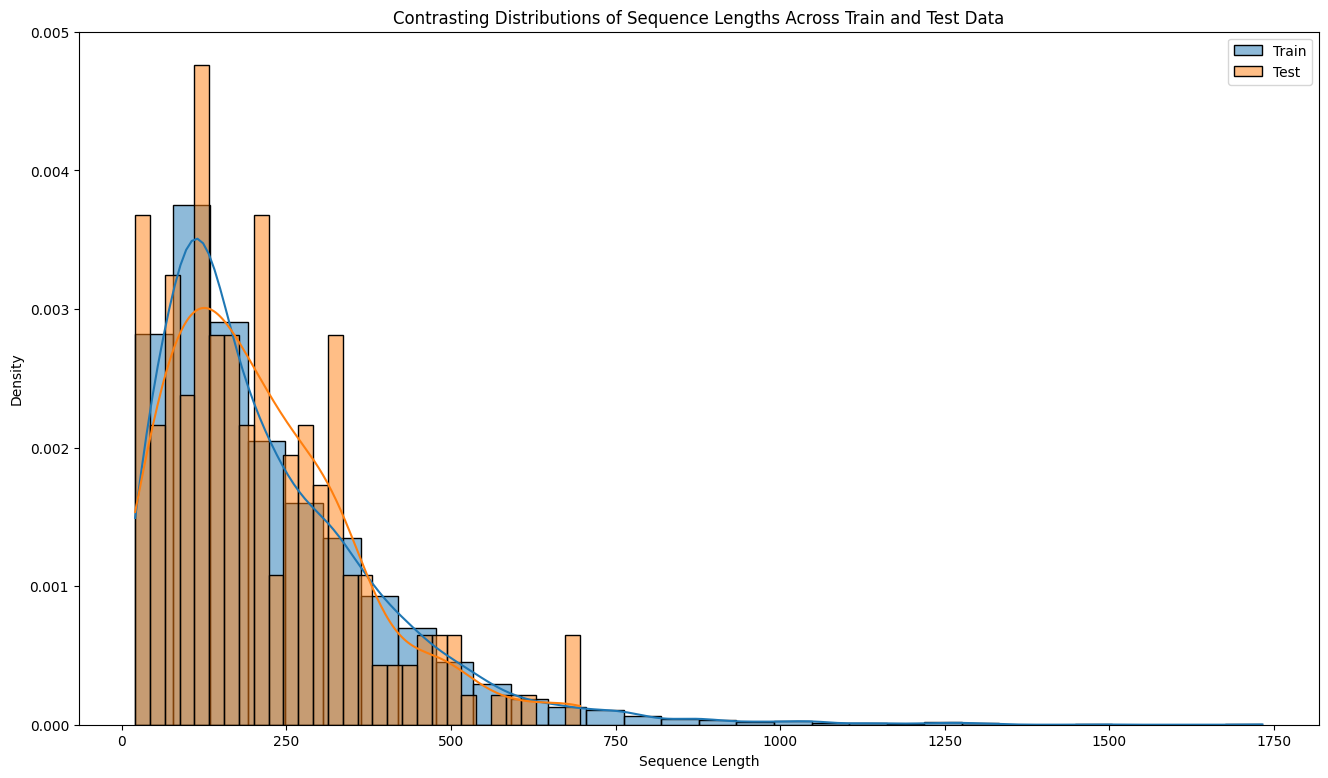

In [5]:
import pandas as pd
def get_sequence_lengths(directory):
    df = pd.read_csv(directory, usecols=['SEQUENCE'])
    return df['SEQUENCE'].apply(len).values

seq_lengths_train = get_sequence_lengths('../data/simplified_seq/seqs_train.csv')
seq_lengths_test = get_sequence_lengths('../data/simplified_seq/seqs_test.csv')

if len(seq_lengths_train) > len(seq_lengths_test):
  padding_length = len(seq_lengths_train) - len(seq_lengths_test)
  padding_values = np.full(padding_length, np.nan)
  seq_lengths_test = np.concatenate((seq_lengths_test, padding_values))
        

sequences_df = pd.DataFrame({'Train':seq_lengths_train, 'Test':seq_lengths_test})

bins = 30
plt.figure(figsize=(16,9))
plt.title('Contrasting Distributions of Sequence Lengths Across Train and Test Data')

sns.histplot(data =sequences_df['Train'],
            bins=bins, 
            kde=True,
            stat='density',
            label='Train',
            legend=True)

sns.histplot(data =sequences_df['Test'],
            bins=bins, 
            kde=True,
            stat='density',
            label='Test',
            legend=True)

plt.xlabel('Sequence Length')
plt.ylabel('Density')
plt.legend()

Train max sequence length: 1733
Test max sequence length: 696.0


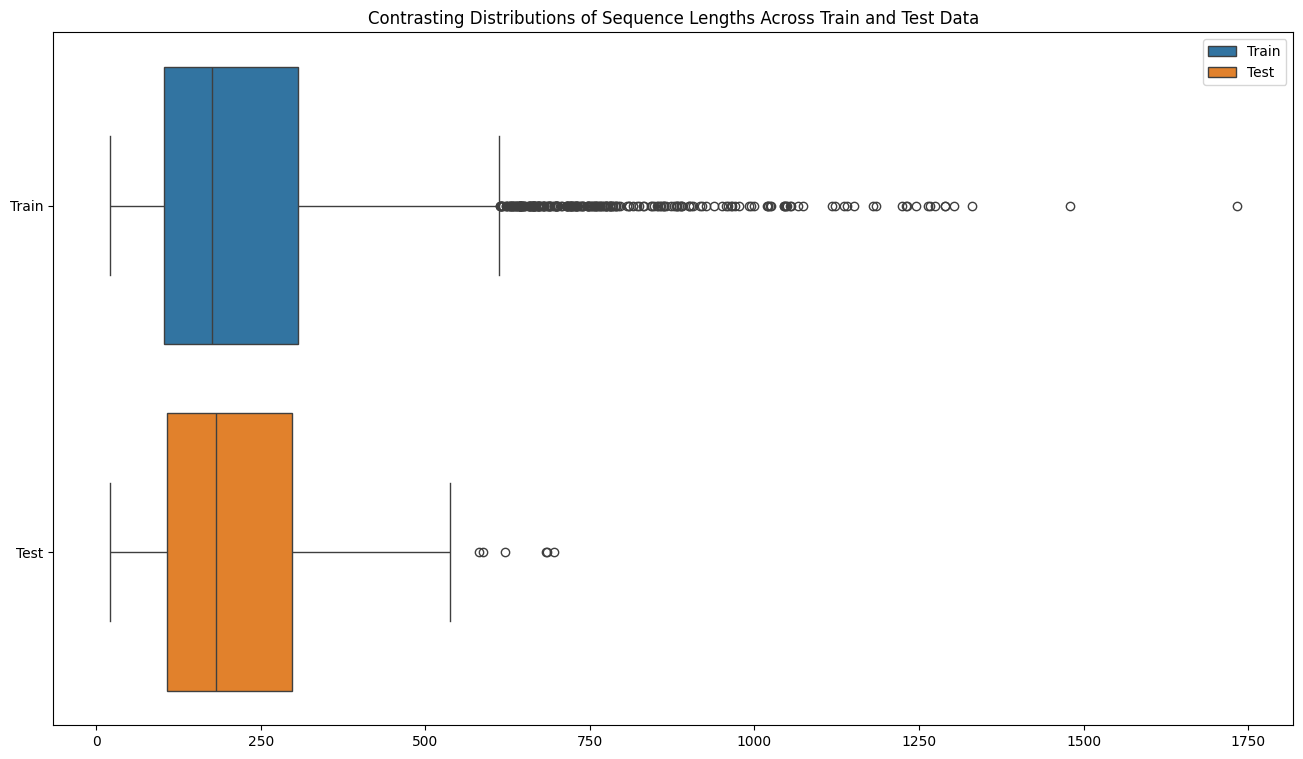

In [6]:
plt.figure(figsize=(16,9))
plt.title('Contrasting Distributions of Sequence Lengths Across Train and Test Data')

sns.boxplot(
    data=sequences_df, 
    orient='h',
    legend=True,
)
print('Train max sequence length:',sequences_df['Train'].max())
print('Test max sequence length:',sequences_df['Test'].max())

#### Analysing at the sequence length distribution
From these visualisations we can observe that the sequence lengths for the training data are often larger than for the test data.

As our input shape to our FCN will have to be able to take in a set max sequence length it may be tempting to remove all training data above a certain threshold to reduce the input size; reducing computation and focusing the model on sequences similar length to the test data. Howver this would cause many issues such as:

* *Loss of Information*:
Long sequences might contain valuable patterns or features that the FCN could learn from. Removing them can limit the model's ability to capture complex relationships in the data.

* *Data Imbalance*: The removed sequences could contain more information on a specific second structure leading to a class imbalance problem, where the model struggles to predict a certain class.

* *Reduced Generalizability*: The FCN might not generalize well to unseen data beyond this competition if it's not trained on a representative distribution of sequence lengths.

#### Using a padding approach to address variable sequence lengths
As this study is not exploring the use of more complex methods such as RNNs we will use padding to deal with the differences in sequence length padding all of the data to the maximum sequence length in our data of 1733.
We can either pad with 0 meaning no amino acids are present or -1 which could be learnt by the model as data not being present.

This will result in a 20 channel (number of different amino acids) by 1733 (max_sequence_length) shape input layer.
* i.e shape (N, 20, max_sequence_length) where N is the batch size


**Protein Secondary Structure**: 

The secondary structure refers to the local folding patterns formed by a protein's amino acid sequence. It's influenced by a combination of factors:
* *Amino Acid Sequence*: The specific sequence of amino acids plays a crucial role in determining the potential secondary structures that can form.
* *Local Interactions*: Nearby amino acids interact with each other, influencing how the protein chain folds in localized regions.
* *Overall Folding Landscape*: The final 3D structure of the protein, including its secondary structures, is influenced by interactions throughout the entire molecule.
* In our data the secondry structure has three posibilites for each position: H = Helix, E = Extended Sheet, C = Coil symbols.

In [7]:
quick_vis = pd.read_csv('../data/labels/labels_train.csv')
quick_vis.head()

,PDB_ID,SEC_STRUCT
0,1VBK_1_A,CCEEEEEECCCCCCCCCCHHHHHHHHHHHHHHHHHHCCCCCCEEEE...
1,1QGV_1_A,CCCCCCECCCHHHHHHHHHCCCCCEEEEEEECCCCHHHHHHHHHHH...
2,1KX6_1_A,CCCCCCCCCCCCCCCCCCCCCCHHHHCCC
3,1V88_1_A,CCCCCCCCCEEEEEEECCCCCCCEEEEEEEECCEEEEECCCCCCCC...
4,1ZY8_2_K,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...


#### Encoding the Secondry Structures
As the secondry structure is given as characters we need to encode it as the model can only understand numerical data. Using One hot encoding we can both encode and decode second structure data.
These functions assume that the output will be as [0 0 0 1], [1 0 0 0] corresponding to each sequence position. You might notice that there are 4 classes here but there are only 3 second structures to predict from. I have added an extra class that means the sequence is over and is mapped to ' '. I have also added max sequence length so that the code could be used for shorter sequences truncating the labels.

In [8]:
def one_hot_encode_sequence(sequence, max_sequence_length):
    encoding = {'H': [1,0,0,0], 'E': [0,1,0,0], 'C': [0,0,1,0], ' ': [0,0,0,1]}
    encoded_sequence = []

    if len(sequence) > max_sequence_length:
        sequence = sequence[:max_sequence_length]
        
    for char in sequence:
        encoded_sequence.extend(encoding[char])
    
        
    num_blanks = max_sequence_length - len(sequence)
    encoded_sequence.extend([0, 0, 0, 1] * num_blanks)
    
    
    
    return torch.tensor(encoded_sequence, dtype=torch.float32).reshape(-1,4)


def decode_output(encoded_sequence, threshold=0.5):
    # the encoded_sequence is a N x 4 x L torch.tensor
    
    sequence = ''
    
    for i in range(encoded_sequence.size(1)):  
        
        if encoded_sequence[0,i,0] >= threshold:
            sequence += 'H'
        elif encoded_sequence[0, i, 1] >= threshold:
            sequence += 'E'
        elif encoded_sequence[0, i, 2] >= threshold:
            sequence += 'C'
        else:
            sequence += ' '
    return sequence


test_string = 'HCEC HCCCEC H'
test_encoded = one_hot_encode_sequence(test_string, 7)
print('Original:', test_string)
print('Encoded:', test_encoded)
print('Encoded shape:', test_encoded.shape)
test_encoded.unsqueeze_(0)
print('Decoded:', decode_output(test_encoded))

Original: HCEC HCCCEC H
Encoded: tensor([[1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.]])
Encoded shape: torch.Size([7, 4])
Decoded: HCEC HC


**Convolutional Neural Networks (CNNs) and Local Interactions**:

 As CNNs are well-suited to capture local sequence features. By applying convolutional layers, the model can analyze patterns within the PSSM data, aiding in predicting the secondary structure based on these local interactions within the protein sequence.
 
 In this study a fully convolutional nueral network (FCN) will be used to predict the secondry structure. We will now create a dataloader for our network given the information we have learnt.


# Creating a Custom pytorch PSSM DataSet and DataLoaders

In [ ]:
class (Dataset):
    """Position-Specific Scoring Matrix (PSSM) Dataset"""

    def __init__(self, pssm_root_dir, sec_struct_file_path,tensor_files_dir,max_sequence_length=1733 transform=None):
        """
        Args:
            pssm_root_dir (string): Directory with all the protein PSSM data.
            sec_struct_root_dir (string): Directory with all the protein secondary structure data. 
            transform (callable, optional): Optional transform to be applied on a sample. (not used here)           
        """
        self.pssm_root_dir = pssm_root_dir
        self.sec_struct_file_path = sec_struct_file_path
        self.tensor_files_dir = tensor_files_dir
        os.makedirs(self.tensor_files_dir, exist_ok=True)
        self.transform = transform 
        
        self.file_list = [file for file in os.listdir(pssm_root_dir) if file.endswith('.csv')]


    def preprocess_and_save_tensors(self): # Depending on system requirements may be memory intensive to run
        
        for file_name in self.file_list:
            
            pssm_csv_file = os.path.join(self.pssm_root_dir, file_name)
            pbd_id = os.path.splitext(file_name)[0]
            pbd_id = ''.join(pbd_id)

            pssm_tensor_file_path = os.path.join(self.tensor_files_dir, f"{pbd_id}.pt")
            sec_struct_tensor_file_path = os.path.join(self.tensor_files_dir, f"{pbd_id}_sec_struct.pt")
      
            
            if not os.path.exists(pssm_tensor_file_path):
                pssm_data = pd.read_csv(pssm_csv_file)
                pssm_data = pssm_data.drop(columns=['RES_NUM', 'AMINO_ACID'], axis=1)
                
                num_zeros = 0
                if len(pssm_data) > max_sequence_length:
                    pssm_data = pssm_data[:max_sequence_length]
                else:               
                    num_zeros = max_sequence_length - len(pssm_data)
                if num_zeros > 0:
                    df_zeros = pd.DataFrame(0, index=range(num_zeros), columns=pssm_data.columns)
                    pssm_data = pd.concat([pssm_data, df_zeros], ignore_index=True)
                
                pssm_data = pssm_data.T.to_numpy()
                pssm_data = torch.tensor(pssm_data, dtype=torch.float32)

                torch.save(pssm_data, pssm_tensor_file_path)
            
                
            elif self.sec_struct_file_path is not None:
                if not os.path.exists(sec_struct_tensor_file_path):

                    sec_struct_data = pd.read_csv(self.sec_struct_file_path)
                        
                    sec_struc_value = sec_struct_data.loc[sec_struct_data['PDB_ID'] == pbd_id, 'SEC_STRUCT'].values[0]
                    encoded_sec_struc = one_hot_encode_sequence(sec_struc_value, max_sequence_length)

                    torch.save(encoded_sec_struc, sec_struct_tensor_file_path)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_name = self.file_list[idx]
        pbd_id = os.path.splitext(file_name)[0]
        pbd_id = ''.join(pbd_id)
        tensor_file_path = os.path.join(self.tensor_files_dir, f"{pbd_id}.pt")
        pssm_data = torch.load(tensor_file_path)
        input = pssm_data

        
        if self.sec_struct_file_path is not None:

            sec_struct_tensor_file_path = os.path.join(self.tensor_files_dir, f"{pbd_id}_sec_struct.pt")
            encoded_sec_struc = torch.load(sec_struct_tensor_file_path) # form like [[0, 0, 0, 1], [0, 1, 0, 0]...]
            target = torch.argmax(encoded_sec_struc,dim=1) # form like [3, 1, ....]
            return input, target
        
        else:
            return pbd_id,input

#### Create datasets based on the train and test data
Preprocess and save tensor files if this has not already been done

In [ ]:
train_val_dataset = PSSM(pssm_root_dir='../data/pssm_csv/train',
                      sec_struct_file_path='../data/labels/labels_train.csv',)

test_dataset = PSSM(pssm_root_dir='../data/pssm_csv/test',
                      sec_struct_file_path=None)

test_dataset.preprocess_and_save_tensors()
train_val_dataset.preprocess_and_save_tensors()

#### Create Dataloaders based on the custom datasets

As the train dataset is relatively large I am using a train val split of 70% rather than cross validation

In [ ]:
train_size = int(0.70 * len(train_val_dataset))
val_size = len(speedy_dataset) - train_size

train_dataset, val_dataset = random_split(speedy_dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset,batch_size=64, shuffle=False)
train_val_dataloader = DataLoader(train_val_dataset, batch_size=64, shuffle=True) # for training the model after hyperparameter tuning

test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)